In [1]:
from __future__ import print_function

import numpy as np
import pandas as pd
import collections
from mpl_toolkits.mplot3d import Axes3D
from IPython import display
from matplotlib import pyplot as plt
from IPython.display import display
import seaborn as sns
import sklearn
import sklearn.manifold
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.logging.set_verbosity(tf.logging.ERROR)

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from collections import Counter, defaultdict
from operator import itemgetter
import tensorflow as tf
from tensorflow import keras
from pylab import rcParams
from pylab import savefig
import lightfm
from lightfm import LightFM
from lightfm.data import Dataset
from lightfm import cross_validation
from lightfm.evaluation import precision_at_k
from lightfm.evaluation import recall_at_k
from lightfm.cross_validation import random_train_test_split
from scipy.sparse import csr_matrix
import scipy
import recmetrics

from sklearn.model_selection import train_test_split
from collections import Counter, defaultdict
from sklearn.metrics import accuracy_score
import matplotlib.ticker as ticker
from math import sqrt
from sklearn.metrics import mean_squared_error

C:\Users\user\anaconda3\lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


In [3]:
# Install Altair and activate its colab renderer.
#print("Installing Altair...")
#!pip install git+git://github.com/altair-viz/altair.git
#import altair as alt
#alt.data_transformers.enable('default', max_rows=None)
#alt.renderers.enable('colab')
#print("Done installing Altair.")

# Install spreadsheets and import authentication module.
#USER_RATINGS = False
#!pip install --upgrade -q gspread
#from google.colab import auth
#import gspread
#from oauth2client.client import GoogleCredentials

In [4]:
import matplotlib.pyplot as plt
import os
import warnings
from keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate
from keras.models import Model

Firstly, I converted my data files from .dat to .csv format. I did this via excel using the data tab and it's "get external data" option and extracted it from text. All the delimiting was done by default and I had my files in a delimited format.

In [5]:
df = pd.read_csv("data/hetrec2011-lastfm-2k/artists.csv")
df

,id,name,url,pictureURL
0,1,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,http://userserve-ak.last.fm/serve/252/10808.jpg
1,2,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,http://userserve-ak.last.fm/serve/252/3052066.jpg
2,3,Carpathian Forest,http://www.last.fm/music/Carpathian+Forest,http://userserve-ak.last.fm/serve/252/40222717...
3,4,Moi dix Mois,http://www.last.fm/music/Moi+dix+Mois,http://userserve-ak.last.fm/serve/252/54697835...
4,5,Bella Morte,http://www.last.fm/music/Bella+Morte,http://userserve-ak.last.fm/serve/252/14789013...
...,...,...,...,...
17627,18741,Diamanda GalÃ¡s,http://www.last.fm/music/Diamanda+Gal%C3%A1s,http://userserve-ak.last.fm/serve/252/16352971...
17628,18742,Aya RL,http://www.last.fm/music/Aya+RL,http://userserve-ak.last.fm/serve/252/207445.jpg
17629,18743,Coptic Rain,http://www.last.fm/music/Coptic+Rain,http://userserve-ak.last.fm/serve/252/344868.jpg
17630,18744,Oz Alchemist,http://www.last.fm/music/Oz+Alchemist,http://userserve-ak.last.fm/serve/252/29297695...


In [6]:
df['id'] = pd.to_numeric(df['id'])
lst = []
m = np.array(df['id'])
for i in range(0,17632):
    #print(i)
    if i not in df.id.values:
        lst.append(i)

len(lst)

965

In [7]:
newart = []
for i in range(0, 17632):
    newart.append(i)

In [8]:
newart = np.array(newart)
df['artID'] = newart.tolist()

In [9]:
df.drop(columns=['id'], inplace=True)
df.head()

,name,url,pictureURL,artID
0,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,http://userserve-ak.last.fm/serve/252/10808.jpg,0
1,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,http://userserve-ak.last.fm/serve/252/3052066.jpg,1
2,Carpathian Forest,http://www.last.fm/music/Carpathian+Forest,http://userserve-ak.last.fm/serve/252/40222717...,2
3,Moi dix Mois,http://www.last.fm/music/Moi+dix+Mois,http://userserve-ak.last.fm/serve/252/54697835...,3
4,Bella Morte,http://www.last.fm/music/Bella+Morte,http://userserve-ak.last.fm/serve/252/14789013...,4


There appears to be some unclean names such as "Diamanda GalÃ¡s" among others just taking an initial look at the data here.

In [10]:
df1 = pd.read_csv("data/hetrec2011-lastfm-2k/tags.csv")
df1

,tagID,tagValue
0,1,metal
1,2,alternative metal
2,3,goth rock
3,4,black metal
4,5,death metal
...,...,...
11941,12644,suomi
11942,12645,symbiosis
11943,12646,sverige
11944,12647,eire


In [11]:
df2 = pd.read_csv("data/hetrec2011-lastfm-2k/user_artists.csv")
df2

,userID,artistID,weight
0,2,51,13883
1,2,52,11690
2,2,53,11351
3,2,54,10300
4,2,55,8983
...,...,...,...
92829,2100,18726,337
92830,2100,18727,297
92831,2100,18728,281
92832,2100,18729,280


In [12]:
df2['artistID'].min()

1

In [13]:
# Since the ids start at 2, we get them to start at 0. We also need to have the max value 1 less than the no of unique values.
df2["userID"] = df2["userID"].apply(lambda x: str(x-2))
df2["artistID"] = df2["artistID"].apply(lambda x: str(x-1))

In [14]:
df2['userID'] = df2['userID'].astype(int)
xyz =  np.array(df2['userID'])
#zzz = np.array(played['userID'])
vals = []
for i in range(len(xyz)):
    v = xyz[i]
    if v not in vals:
        vals.append(v)
    else:
        continue

In [15]:
vals[-1]

2098

In [16]:
unique_list = list(set(vals))
unique_list.sort()
unique_list[-1]

2098

In [17]:
usenew = []
for i in range(0, 1892):
    usenew.append(i)

usenew[-1]

1891

In [18]:
keys = unique_list
values = usenew
dictionary = dict(zip(keys, values))
#print(dictionary) # {'a': 1, 'b': 2, 'c': 3}

In [19]:
s = df2['userID']

df2['userID'] = s.map(dictionary)

In [20]:
df2.head()

,userID,artistID,weight
0,0,50,13883
1,0,51,11690
2,0,52,11351
3,0,53,10300
4,0,54,8983


In [21]:
df2['artistID'] = df2['artistID'].astype(int)
xyz =  np.array(df2['artistID'])
#zzz = np.array(played['userID'])
vals = []
for i in range(len(xyz)):
    v = xyz[i]
    if v not in vals:
        vals.append(v)
    else:
        continue

In [22]:
unique_list = list(set(vals))
unique_list.sort()
unique_list[0]

0

In [23]:
usenew = []
for i in range(0, 17632):
    usenew.append(i)

usenew[-1]

17631

In [24]:
keys = unique_list
values = usenew
diction = dict(zip(keys, values))
#print(diction) # {'a': 1, 'b': 2, 'c': 3}

In [25]:
s = df2['artistID']

df2['artistID'] = s.map(diction)

In [26]:
df2['weight'].max()

352698

In [27]:
df2

,userID,artistID,weight
0,0,45,13883
1,0,46,11690
2,0,47,11351
3,0,48,10300
4,0,49,8983
...,...,...,...
92829,1891,17615,337
92830,1891,17616,297
92831,1891,17617,281
92832,1891,17618,280


In [28]:
df3 = pd.read_csv("data/hetrec2011-lastfm-2k/user_friends.csv")
df3

,userID,friendID
0,2,275
1,2,428
2,2,515
3,2,761
4,2,831
...,...,...
25429,2099,1801
25430,2099,2006
25431,2099,2016
25432,2100,586


In [29]:
# Since the ids start at 2, we get them to start at 0. We also need to have the max value 1 less than the no of unique values.
df3["userID"] = df3["userID"].apply(lambda x: str(x-2))
df3["friendID"] = df3["friendID"].apply(lambda x: str(x-2))

df3['userID'] = pd.to_numeric(df3['userID'])
df3['friendID'] = pd.to_numeric(df3['friendID'])

In [30]:
df3['friendID'].max()

2098

In [31]:
df3['friendID'].nunique()

1892

In [32]:
xyz =  np.array(df3['userID'])
#zzz = np.array(df2['userID'])
vals = []
for i in range(len(xyz)):
    if xyz[i] not in vals:
        vals.append(xyz[i])

In [33]:
unique_list = list(set(vals))
unique_list.sort()
unique_list[-1]

2098

In [34]:
usenew = []
for i in range(0, 1892):
    usenew.append(i)

usenew[-1]

1891

In [35]:
keys = unique_list
values = usenew
dictionary = dict(zip(keys, values))
#print(dictionary) # {'a': 1, 'b': 2, 'c': 3}

In [36]:
s = df3['userID']

df3['userID'] = s.map(dictionary)

In [37]:
o = df3['friendID']

df3['friendID'] = o.map(dictionary)

In [38]:
df3['friendID'].max()

1891

In [39]:
df3.isnull().values.any()

False

In [40]:
df4 = pd.read_csv("data/hetrec2011-lastfm-2k/user_taggedartists-timestamps.csv")
df4

,userID,artistID,tagID,day,month,year
0,2,52,13,1,4,2009
1,2,52,15,1,4,2009
2,2,52,18,1,4,2009
3,2,52,21,1,4,2009
4,2,52,41,1,4,2009
...,...,...,...,...,...,...
186474,2100,16437,4,1,7,2010
186475,2100,16437,292,1,5,2010
186476,2100,16437,2087,1,7,2010
186477,2100,16437,2801,1,5,2010


In [41]:
df5 = pd.read_csv("data/hetrec2011-lastfm-2k/user_taggedartists.csv")
df5.head()

,userID,artistID,tagID,day,month,year
0,2,52,13,1,4,2009
1,2,52,15,1,4,2009
2,2,52,18,1,4,2009
3,2,52,21,1,4,2009
4,2,52,41,1,4,2009


Our last two dataframes seem exactly the same. Let's check this before we delete anything.

In [42]:
def checkequality(A, B):

    df11 = A.sort_index(axis=1)
    df11 = df11.sort_values(df11.columns.tolist()).reset_index(drop=True)

    df22 = B.sort_index(axis=1)
    df22 = df22.sort_values(df22.columns.tolist()).reset_index(drop=True)
    return (df11 == df22).values.all()

a = checkequality(df4, df5)
print (a)

True


Two of our files are exactly the same. We can delete one of these accordingly.

In [43]:
del df5

In [44]:
# Since the ids start at 2, we get them to start at 0. We also need to have the max value 1 less than the no of unique values.
df4["userID"] = df4["userID"].apply(lambda x: str(x-2))
df4["artistID"] = df4["artistID"].apply(lambda x: str(x-1))

df4['artistID'] = df4['artistID'].astype(int)
df4['userID'] = df4['userID'].astype(int)

In [45]:
xyz =  np.array(df4['artistID'])
#zzz = np.array(played['userID'])
vals = []
for i in range(len(xyz)):
    v = xyz[i]
    if v not in vals:
        vals.append(v)
    else:
        continue

In [46]:
unique_list = list(set(vals))
unique_list.sort()
print(unique_list[-1])

usenew = []
for i in range(0, 17632):
    usenew.append(i)

usenew[-1]

18743


17631

In [47]:
keys = unique_list
values = usenew
diction = dict(zip(keys, values))
#print(diction) # {'a': 1, 'b': 2, 'c': 3}

In [48]:
s = df4['artistID']

df4['artistID'] = s.map(diction)

In [49]:
s = df4['userID']

df4['userID'] = s.map(dictionary)
#print(dictionary)

In [50]:
df4

,userID,artistID,tagID,day,month,year
0,0,49,13,1,4,2009
1,0,49,15,1,4,2009
2,0,49,18,1,4,2009
3,0,49,21,1,4,2009
4,0,49,41,1,4,2009
...,...,...,...,...,...,...
186474,1891,11288,4,1,7,2010
186475,1891,11288,292,1,5,2010
186476,1891,11288,2087,1,7,2010
186477,1891,11288,2801,1,5,2010


In [51]:
df4.drop(columns=['day', 'month', 'year'], inplace=True)

In [52]:
tags = pd.merge(df1, df4, how="inner", left_on="tagID", right_on="tagID")
tags.isnull().values.any()
tags['artistID'].max()

12522

# Methodology
Now that all our data files are read in and in the appropriate format we will begin our end to end process. These are as follows:
##### 1. Data cleaning and processing
##### 2. Visualization
##### 3. Fitting our Model
##### 4. Evaluating our Model

# Cleaning and Processing

### Initial analysis and cleaning

In [53]:
df['name'].value_counts()

MALICE MIZER                        1
BEAT!BEAT!BEAT!                     1
ãƒˆã‚¯ãƒžãƒ«ã‚·ãƒ¥ãƒ¼ã‚´            1
Thao with The Get Down Stay Down    1
ãƒªã‚¢ãƒ»ãƒ‡ã‚£ã‚¾ãƒ³               1
                                   ..
Innerpartysystem                    1
Helia                               1
Devil Sold His Soul                 1
Nevea Tears                         1
Grzegorz Tomczak                    1
Name: name, Length: 17632, dtype: int64

In [54]:
df1['tagID'].value_counts()

1        1
8368     1
8359     1
8360     1
8361     1
        ..
4059     1
4060     1
4061     1
4062     1
12648    1
Name: tagID, Length: 11946, dtype: int64

After initial observation, I feel the timestamp dataframe is of little use to me and hence disregard it. As per the readme file we have 1892 users and 17632 artists in our data.

In [55]:
dfs = [df, df1, df2, df3, df4]
na = []
for i in range(len(dfs)):
    if dfs[i].isnull().values.any() > 0:
        na.append(dfs[i])

In [56]:
na

[                    name                                           url  \
 0           MALICE MIZER         http://www.last.fm/music/MALICE+MIZER   
 1        Diary of Dreams      http://www.last.fm/music/Diary+of+Dreams   
 2      Carpathian Forest    http://www.last.fm/music/Carpathian+Forest   
 3           Moi dix Mois         http://www.last.fm/music/Moi+dix+Mois   
 4            Bella Morte          http://www.last.fm/music/Bella+Morte   
 ...                  ...                                           ...   
 17627    Diamanda GalÃ¡s  http://www.last.fm/music/Diamanda+Gal%C3%A1s   
 17628             Aya RL               http://www.last.fm/music/Aya+RL   
 17629        Coptic Rain          http://www.last.fm/music/Coptic+Rain   
 17630       Oz Alchemist         http://www.last.fm/music/Oz+Alchemist   
 17631   Grzegorz Tomczak     http://www.last.fm/music/Grzegorz+Tomczak   
 
                                               pictureURL  artID  
 0        http://userserve-ak.l

The only dataframe with nulls is our artists dataframe. Let's investigate this further to see if there is any important missing values such as ID's etc.

In [57]:
df.dtypes

name          object
url           object
pictureURL    object
artID          int64
dtype: object

In [58]:
features_with_na = [features for features in df.columns if df[features].isnull().sum() > 0]

for feature in features_with_na: 
    print(feature, np.round(df[feature].isnull().mean(), 4), '% missing values')
    print(features_with_na)

pictureURL 0.0252 % missing values
['pictureURL']


This is a positive result as there are very few null values in the dataframe and the small amount that exist are in a column of lesser important that we will not need to impute missing values for.

In [59]:
played = pd.merge(df, df2, how="inner", left_on="artID", right_on="artistID")
played.rename(columns={"weight": "played"}, inplace=True)

We will drop the pictureURL column as there is not much information to be gained and there is some nulls present.

In [60]:
played.drop(columns=['pictureURL'], inplace=True)

In [61]:
mean = played['played'].mean()
print("The mean number of times a user listens to a song is: " + str(mean))

The mean number of times a user listens to a song is: 745.2439300256372


In [62]:
median = played['played'].median()
print("The median number of times a user listens to a song is: " + str(median))

The median number of times a user listens to a song is: 260.0


<AxesSubplot:>

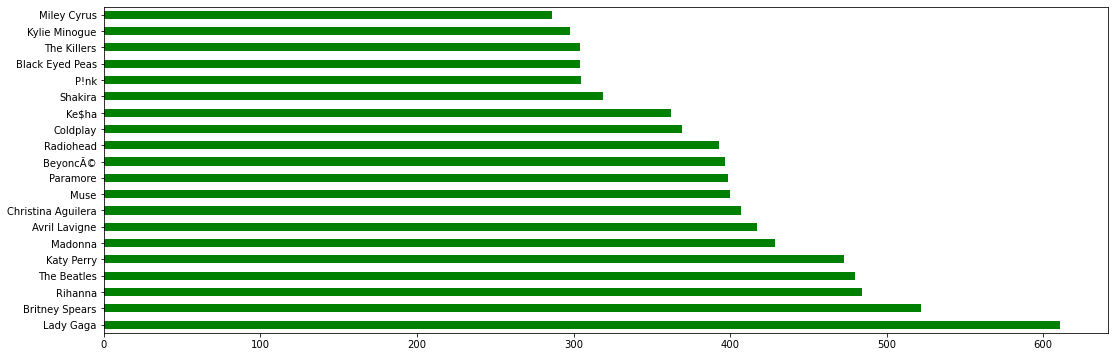

In [63]:
played['name'].value_counts()[:20].plot(kind='barh', color='green', figsize=(18,6))

<AxesSubplot:xlabel='played'>

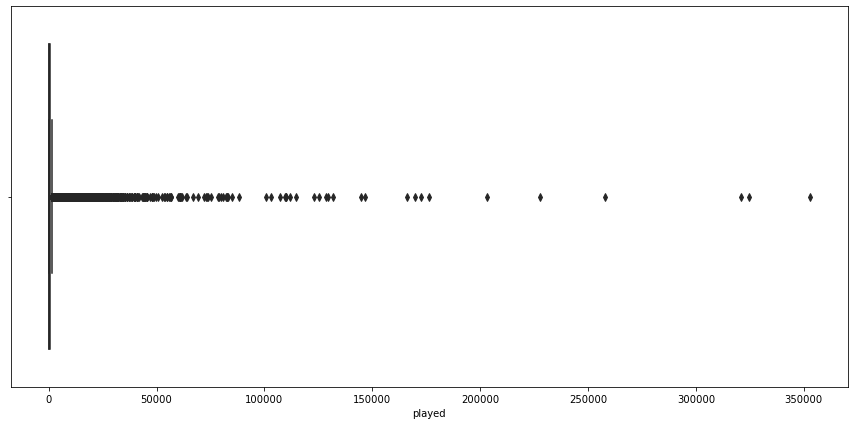

In [64]:
plt.figure(figsize=[15,7])
sns.boxplot(x=played['played'], color=".25")

There appears to be quite a lot of outliers here in the played column. Some users have obviously listened to their songs far more times than the average. We double check our values for mean and median earlier and can confirm there are quite a few outliers here.

In [65]:
played.describe()

,artID,userID,artistID,played
count,92834.000000,92834.000000,92834.000000,92834.00000
mean,3235.736724,944.222483,3235.736724,745.24393
std,4197.216910,546.751074,4197.216910,3751.32208
min,0.000000,0.000000,0.000000,1.00000
25%,430.000000,470.000000,430.000000,107.00000
50%,1237.000000,944.000000,1237.000000,260.00000
75%,4266.000000,1416.000000,4266.000000,614.00000
max,17631.000000,1891.000000,17631.000000,352698.00000


In [66]:
grouped_multiple = played.groupby(['artistID', 'name']).agg({'played': ['mean', 'median', 'max', 'sum']})
grouped_multiple.columns = ['mean', 'med', 'max', 'sum']
grouped_multiple = grouped_multiple.reset_index()
#grouped_multiple.sort('price_mean', ascending=False)
grouped_multiple = pd.DataFrame(grouped_multiple)

In [67]:
artdf = grouped_multiple.sort_values(by=['sum'], ascending=False)

In [68]:
artdf

,artistID,name,mean,med,max,sum
283,283,Britney Spears,4584.559387,1000.5,131733,2393140
66,66,Depeche Mode,4614.567376,567.0,352698,1301308
83,83,Lady Gaga,2113.563011,590.0,114672,1291387
286,286,Christina Aguilera,2600.503686,739.0,176133,1058405
492,492,Paramore,2414.659148,417.0,227829,963449
...,...,...,...,...,...,...
16522,16522,K-Precise,1.000000,1.0,1,1
13713,13713,ZÃœNDER,1.000000,1.0,1,1
13712,13712,Evil Masquerade,1.000000,1.0,1,1
16239,16239,Gosling,1.000000,1.0,1,1


In [69]:
pt2 = artdf.head(20)

<AxesSubplot:title={'center':'Biggest artists by no of listens'}, xlabel='Artist', ylabel='Listens (millions)'>

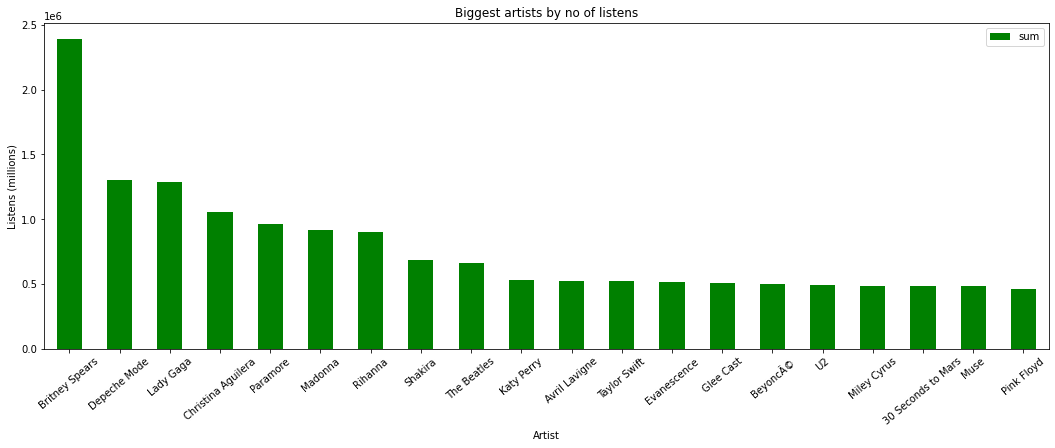

In [70]:
pt2.plot.bar(x = 'name', y = 'sum', rot = 40, figsize=(18, 6), color='green', xlabel='Artist', ylabel='Listens (millions)', title='Biggest artists by no of listens')

In [71]:
grouped_multiple = played.groupby(['userID']).agg({'played': ['mean', 'median', 'max', 'sum']})
grouped_multiple.columns = ['mean', 'med', 'max', 'sum']
grouped_multiple = grouped_multiple.reset_index()
#grouped_multiple.sort('price_mean', ascending=False)
grouped_multiple = pd.DataFrame(grouped_multiple)

In [72]:
userdf = grouped_multiple.sort_values(by=['sum'], ascending=False)

In [73]:
pt3 = userdf.head(20)

<AxesSubplot:title={'center':'Users by highest number of listens'}, xlabel='User', ylabel='Listens'>

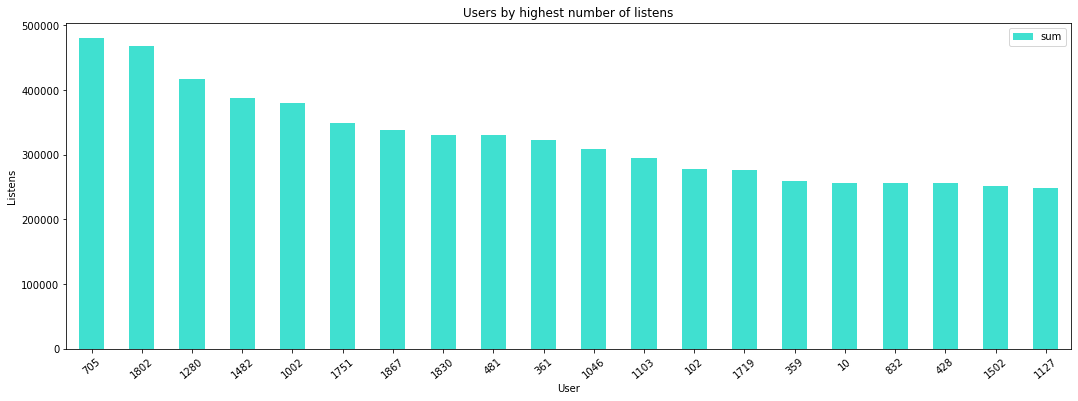

In [74]:
pt3.plot.bar(x = 'userID', y = 'sum', rot = 40, figsize=(18, 6), color='turquoise', xlabel='User', ylabel='Listens', title='Users by highest number of listens')

In [75]:
artdf['mean']

283      4584.559387
66       4614.567376
83       2113.563011
286      2600.503686
492      2414.659148
            ...     
16522       1.000000
13713       1.000000
13712       1.000000
16239       1.000000
16241       1.000000
Name: mean, Length: 17632, dtype: float64

In [76]:
played.shape

(92834, 6)

C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Density')

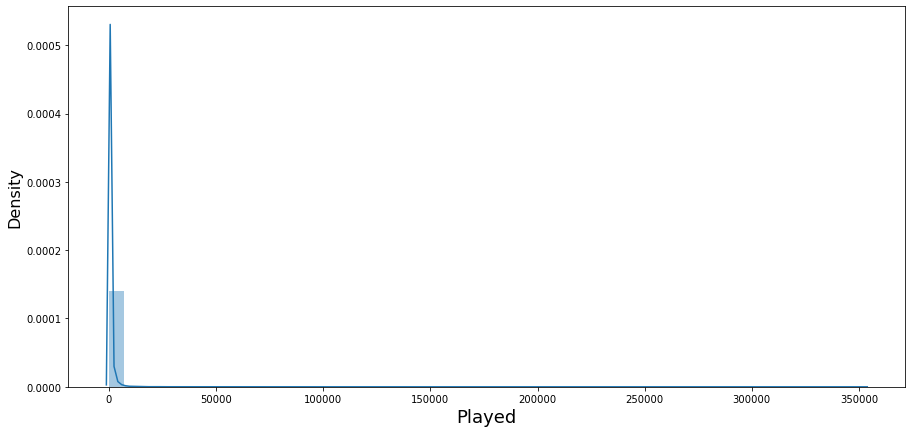

In [77]:
plt.figure(figsize=[15,7])
sns.distplot(played['played'])
plt.xlabel('Played', fontsize=18)
plt.ylabel('Density', fontsize=16)

The majority of values seem around the 1k or less mark. There are a lot of outlier values however going as far as 350,000 for the most extreme values. This confirms our earlier boxplot looking at these values in a clear manner.

In [78]:
xyz = pd.DataFrame(played['name'].value_counts())

In [79]:
xyz = xyz.reset_index()

In [80]:
xyz.rename(columns={'index': 'name', 'name': 'unique'}, inplace=True)

In [81]:
xyz

,name,unique
0,Lady Gaga,611
1,Britney Spears,522
2,Rihanna,484
3,The Beatles,480
4,Katy Perry,473
...,...,...
17627,Karmina,1
17628,Alexandre Desplat & Aaron Zigman,1
17629,Burning Brides,1
17630,ozzy,1


In [82]:
merged_df = artdf.merge(xyz, how = 'inner', on = ['name', 'name'])

In [83]:
merged_df

,artistID,name,mean,med,max,sum,unique
0,283,Britney Spears,4584.559387,1000.5,131733,2393140,522
1,66,Depeche Mode,4614.567376,567.0,352698,1301308,282
2,83,Lady Gaga,2113.563011,590.0,114672,1291387,611
3,286,Christina Aguilera,2600.503686,739.0,176133,1058405,407
4,492,Paramore,2414.659148,417.0,227829,963449,399
...,...,...,...,...,...,...,...
17627,16522,K-Precise,1.000000,1.0,1,1,1
17628,13713,ZÃœNDER,1.000000,1.0,1,1,1
17629,13712,Evil Masquerade,1.000000,1.0,1,1,1
17630,16239,Gosling,1.000000,1.0,1,1,1


In [84]:
percent = []
val = merged_df['unique']
total = played['userID'].nunique()
percent = []
for i in range(len(val)):
    y = val[i] / total
    percent.append(y)
    #print(y)

In [85]:
percent = np.array(percent)
artdf['Percentage'] = percent.tolist()

In [86]:
artdf

,artistID,name,mean,med,max,sum,Percentage
283,283,Britney Spears,4584.559387,1000.5,131733,2393140,0.275899
66,66,Depeche Mode,4614.567376,567.0,352698,1301308,0.149049
83,83,Lady Gaga,2113.563011,590.0,114672,1291387,0.322939
286,286,Christina Aguilera,2600.503686,739.0,176133,1058405,0.215116
492,492,Paramore,2414.659148,417.0,227829,963449,0.210888
...,...,...,...,...,...,...,...
16522,16522,K-Precise,1.000000,1.0,1,1,0.000529
13713,13713,ZÃœNDER,1.000000,1.0,1,1,0.000529
13712,13712,Evil Masquerade,1.000000,1.0,1,1,0.000529
16239,16239,Gosling,1.000000,1.0,1,1,0.000529


In [87]:
artdf['unique'] = merged_df['unique'].values

In [88]:
artdf

,artistID,name,mean,med,max,sum,Percentage,unique
283,283,Britney Spears,4584.559387,1000.5,131733,2393140,0.275899,522
66,66,Depeche Mode,4614.567376,567.0,352698,1301308,0.149049,282
83,83,Lady Gaga,2113.563011,590.0,114672,1291387,0.322939,611
286,286,Christina Aguilera,2600.503686,739.0,176133,1058405,0.215116,407
492,492,Paramore,2414.659148,417.0,227829,963449,0.210888,399
...,...,...,...,...,...,...,...,...
16522,16522,K-Precise,1.000000,1.0,1,1,0.000529,1
13713,13713,ZÃœNDER,1.000000,1.0,1,1,0.000529,1
13712,13712,Evil Masquerade,1.000000,1.0,1,1,0.000529,1
16239,16239,Gosling,1.000000,1.0,1,1,0.000529,1


In [89]:
artdf['Percentage'] = artdf['Percentage'].multiply(100)

In [90]:
artdf = artdf.sort_values(by=['Percentage'], ascending=False)

<AxesSubplot:title={'center':'Percentage of users who listen to most popular artists'}, xlabel='Artist', ylabel='% of unique users who listen'>

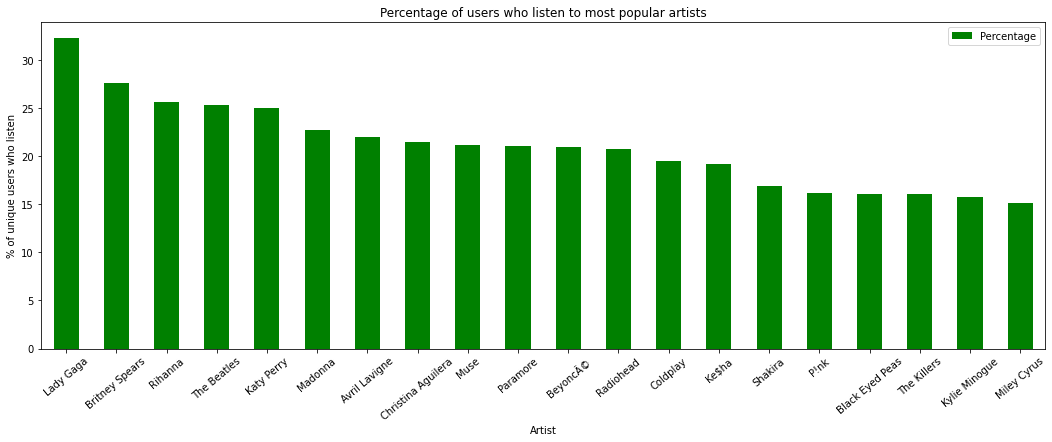

In [91]:
pt2 = artdf.head(20)
pt2.plot.bar(x = 'name', y = 'Percentage', rot = 40, figsize=(18, 6), color='green', xlabel='Artist', ylabel='% of unique users who listen', title='Percentage of users who listen to most popular artists')

In [92]:
values = [1, 2, 3, 4, 5]
for i in range(len(values)):
    x = len(artdf[artdf['Percentage'] <= values[i]])
    print("The percentage of artists with " + str(values[i]) + "% or less users listening to them is " + str(x) + ".")

The percentage of artists with 1% or less users listening to them is 16794.
The percentage of artists with 2% or less users listening to them is 17200.
The percentage of artists with 3% or less users listening to them is 17350.
The percentage of artists with 4% or less users listening to them is 17430.
The percentage of artists with 5% or less users listening to them is 17497.


We can tell on the whole of the 17632 artists that there are actually very few who are listened to by a wide audience. There are less than 1000 artists who have more than 1% of users listening to them. This means our data is probably leaned very heavily towards the most popular artists such as Britney Spears or Lady Gaga as per our barchart above.

In [93]:
z = played[['name', 'artistID']]

In [94]:
z = z.drop_duplicates()

I was going to try to incorporate the tags as part of my recommender system but as per above I seem to lose data just by the shape and even looking at artistID 1 we see this ID occurs three times in our played data and only twice in our tagged dataset. This is porbably due to the fact the users left no tags on this. We also have some improper values for tags as per above such as "better than lady gaga" and "#NAME?" which aren't going to add any information to our data. If we choose a subset of tags and take out values such as these that aren't as common or add any information we could work with this then. However, this would mean trimming our dataset down further. With less data to work with this might negatively impact the effectiveness of our recommender system.

In [95]:
df4[df4['artistID'] == 1]

,userID,artistID,tagID
3251,37,1,30
3252,37,1,127
3253,37,1,575
21145,211,1,61
26470,247,1,30
31456,303,1,30
31457,303,1,179
31458,303,1,575
66247,649,1,14
66248,649,1,233


This confirms that user 34 does not leave a tag on this artist's work. This is why we lose the rows we do when we try to incorporate the tags data into the listened data. We will disregard this for now.

<AxesSubplot:>

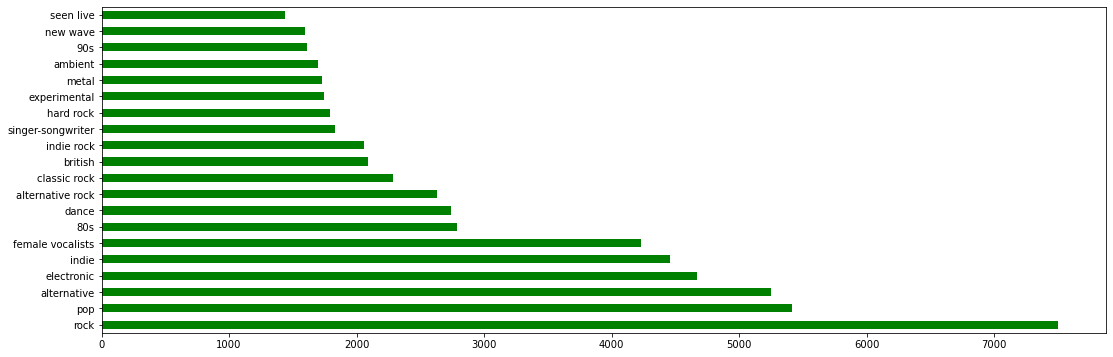

In [96]:
# Let's check most popular tags
tags['tagValue'].value_counts()[:20].plot(kind='barh', color='green', figsize=(18,6))

# Sparse Representation of Played matrix

In [97]:
# Calculate sparsity of matrix
def calculate_sparsity(M):
    matrix_size = float(M.shape[0] * M.shape[1]) # Number of total possible interactions between artist and user in the matrix
    num_plays = len(M.nonzero()[1]) # Number of times any artist has been interacted with
    sparsity = 100 * (1 - float(num_plays / matrix_size))
    return sparsity

## Normalising our played column
Next, one of the crucial aspects of our recommender system would be dealing with our played column. With such a diverse number of values from the range of 0 to over 350,000 we would have to deal with these appropriately. Our system would not be able to handle values of such a high nature and when I tried to run this I would get very high train errors and "nan" values for test error. I looked at a variety of different ways to normalize this value as a result and I would only incorporate two of these into my dataframe. I looked at capping any values above the 2,000 mark in our played column at 2,000 but errors persisted with this approach. As a result the methods I looked at were:

##### 1) Simple Normalization - normalizing all values based off the highest value in the "played" column.

##### 2) User based Normalization - grouping our played column by users and normalizing each user based off their own max value. I implemented this as a column called "playedUserNorm". This had the best results and was the column I implemented below.

##### 3) Play Count Scaled - here I would take each value in the column and take it away from the minimum value in the column. I would then divide this by the max value of the column minus the minimum value. I implemented this with the column "playCountScaled".

##### 4) Robust Scaling method - here we would scale each feature of the data set by subtracting the median and then dividing by the interquartile range. I tried this method but the results were poor and implementing it took a long time to run.


In [98]:
sm = played['played'].groupby(played['userID']).max()
artss = np.array(played['userID'])
playzz = np.array(played['played'])
#artss[-1]
newnorm = []
for i in range(len(playzz)):
    index = artss[i]
    val = playzz[i] / sm[index]
    newnorm.append(val)

In [99]:
newnorm = np.array(newnorm)

#add newnorm array as new column in DataFrame
played['playedUserNorm'] = newnorm.tolist()

In [100]:
played['playedUserNorm'].max()

1.0

In [101]:
pc = played.played
play_count_scaled = (pc - pc.min()) / (pc.max() - pc.min())

played = played.assign(playCountScaled=play_count_scaled)

In [102]:
# !!! here is our 1) simple normalisation

# played["playBasicNorm"] = played["played"] / played["played"].max()

In [103]:
# played['playCountScaled'].equals(played['playBasicNorm'])

In [104]:
played.head()

,name,url,artID,userID,artistID,played,playedUserNorm,playCountScaled
0,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,0,31,0,212,0.055775,0.000598
1,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,0,256,0,483,0.065394,0.001367
2,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,0,729,0,76,0.025149,0.000213
3,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,1,130,1,1021,0.150902,0.002892
4,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,1,240,1,152,0.154315,0.000428


In [105]:
# !!! here is our attempt at robust scaling as per 4) 

#newcol = []
#pl = np.array(played['played'])
#for i in range(len(pl)):
#    val = (pl[i] - played['played'].median())  / (played['played'].quantile(0.75) - played['played'].quantile(0.25))
#    newcol.append(val)

In [106]:
#newcol = np.array(newcol)

#add newnorm array as new column in DataFrame
#played['playedRobust'] = newcol.tolist()

In [107]:
def build_rating_sparse_tensor(ratings_df):
  # ========================= Complete this section ============================
    indices = ratings_df[['userID', 'artID']].values
    values = ratings_df['playedUserNorm'].values
  # ============================================================================

    return tf.SparseTensor(
      indices=indices,
      values=values,
      dense_shape=[len(played.userID.unique()), len(played.artID.unique())])

In [108]:
len(played.userID.unique())

1892

In [109]:
def sparse_mean_square_error(sparse_ratings, user_embeddings, artist_embeddings):
    predictions = tf.reduce_sum(
    tf.gather(user_embeddings, sparse_ratings.indices[:, 0]) * tf.gather(artist_embeddings, sparse_ratings.indices[:, 1]),
      axis=1)
    loss = tf.losses.mean_squared_error(sparse_ratings.values, predictions)
    return loss

# Building Model

In [110]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
class CFModel(object):

  def __init__(self, embedding_vars, loss, metrics=None):

    self._embedding_vars = embedding_vars
    self._loss = loss
    self._metrics = metrics
    self._embeddings = {k: None for k in embedding_vars}
    self._session = None

  @property
  def embeddings(self):
    """The embeddings dictionary."""
    return self._embeddings

  def train(self, num_iterations = 100, learning_rate = 1.0, plot_results=True,
            optimizer=tf.train.GradientDescentOptimizer):

    with self._loss.graph.as_default():
      opt = optimizer(learning_rate)
      train_op = opt.minimize(self._loss)
      local_init_op = tf.group(
          tf.variables_initializer(opt.variables()),
          tf.local_variables_initializer())
      if self._session is None:
        self._session = tf.Session()
        with self._session.as_default():
          self._session.run(tf.global_variables_initializer())
          self._session.run(tf.tables_initializer())
          tf.train.start_queue_runners()

    with self._session.as_default():
      local_init_op.run()
      iterations = []
      metrics = self._metrics or ({},)
      metrics_vals = [collections.defaultdict(list) for _ in self._metrics]

      # Train and append results.
      for i in range(num_iterations + 1):
        _, results = self._session.run((train_op, metrics))
        if (i % 10 == 0) or i == num_iterations:
          print("\r iteration %d: " % i + ", ".join(
                ["%s=%f" % (k, v) for r in results for k, v in r.items()]),
                end='')
          iterations.append(i)
          for metric_val, result in zip(metrics_vals, results):
            for k, v in result.items():
              metric_val[k].append(v)

      for k, v in self._embedding_vars.items():
        self._embeddings[k] = v.eval()

      if plot_results:
        # Plot the metrics.
        num_subplots = len(metrics) + 1
        fig = plt.figure()
        fig.set_size_inches(num_subplots * 10, 8)
        for i, metric_vals in enumerate(metrics_vals):
          ax = fig.add_subplot(1, num_subplots, i + 1)
          for k, v in metric_vals.items():
            ax.plot(iterations, v, label = k)
          ax.set_xlim([1, num_iterations])
          ax.legend()
      return results

# Build and Run the Model

In [111]:
from sklearn.model_selection import train_test_split
def build_model(ratings, embedding_dim=3, init_stddev=1.):

  # Split the ratings DataFrame into train and test.
    #train_ratings, test_ratings = train_test_split(ratings, test_size=0.5)
    train_ratings, test_ratings = split_dataframe(ratings)
  # SparseTensor representation of the train and test datasets.
    A_train = build_rating_sparse_tensor(train_ratings)
    A_test = build_rating_sparse_tensor(test_ratings)
  # Initialize the embeddings using a normal distribution.
    U = tf.Variable(tf.random.normal(
      [A_train.dense_shape[0], embedding_dim], stddev=init_stddev))
    V = tf.Variable(tf.random.normal(
      [A_train.dense_shape[1], embedding_dim], stddev=init_stddev))
    train_loss = sparse_mean_square_error(A_train, U, V)
    test_loss = sparse_mean_square_error(A_test, U, V)
    metrics = {
      'train_error': train_loss,
      'test_error': test_loss
    }
    embeddings = {
      "userID": U,
      "artID": V
    }
    return CFModel(embeddings, train_loss, [metrics])

In [112]:
def split_dataframe(df, holdout_fraction=0.3):
  
    test = df.sample(frac=holdout_fraction, replace=False)
    train = df[~df.index.isin(test.index)]
    return train, test

In [113]:
xyz = played[['userID', 'artID', 'playedUserNorm']]

 iteration 1000: train_error=0.032257, test_error=0.694457

[{'train_error': 0.032257475, 'test_error': 0.6944568}]

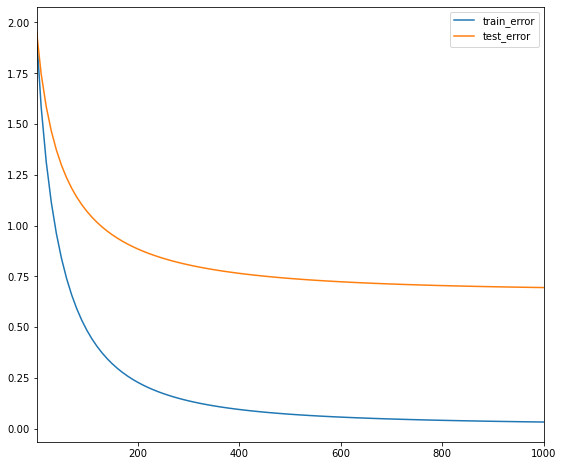

In [114]:
model = build_model(xyz,  embedding_dim=30, init_stddev=0.5)
model.train(num_iterations=1000, learning_rate=10.)

I tried to build my model but the high values for listens was giving me errors like so "InvalidArgumentError: indices[4073] = 2077 is not in [0, 1892)". 

This was why I changed the artist and user ID's to 1.) start from zero and 2.) increment by 1 until the length of unique values - 1. I had to normalise my weights then as I kept returning nan values for train and test errors above.

In [115]:
played.head(6)

,name,url,artID,userID,artistID,played,playedUserNorm,playCountScaled
0,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,0,31,0,212,0.055775,0.000598
1,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,0,256,0,483,0.065394,0.001367
2,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,0,729,0,76,0.025149,0.000213
3,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,1,130,1,1021,0.150902,0.002892
4,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,1,240,1,152,0.154315,0.000428
5,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,1,303,1,3466,1.000000,0.009824


In [116]:
#played[played["played"] > 2000]["played"] = 2000

In [117]:
#indexes = played[played["played"] > 2000].index

In [118]:
#played.iloc[indexes,5] = 2000

In [119]:
#played.head()

# Inspect Embeddings

In [120]:
DOT = 'dot'
COSINE = 'cosine'
def compute_scores(query_embedding, item_embeddings, measure=DOT):
  u = query_embedding
  V = item_embeddings
  if measure == COSINE:
    V = V / np.linalg.norm(V, axis=1, keepdims=True)
    u = u / np.linalg.norm(u)
  scores = u.dot(V.T)
  return scores

In [121]:
from IPython import display
def artist_neighbors(model, title_substring, measure=DOT, k=6):
  ids =  df[df['name'].str.contains(title_substring)].index.values
  titles = df.iloc[ids]['name'].values
  if len(titles) == 0:
    raise ValueError("Found no artist with title %s" % title_substring)
  print("Nearest neighbors of : %s." % titles[0])
  if len(titles) > 1:
    print("[Found more than one matching artist. Other candidates: {}]".format(
        ", ".join(titles[1:])))
  artistID = ids[0]
  scores = compute_scores(
      model.embeddings["artID"][artistID], model.embeddings["artID"],
      measure)
  score_key = measure + ' score'
  df7 = pd.DataFrame({
      score_key: list(scores),
      'names': df['name'],
  })
  display.display(df7.sort_values([score_key], ascending=False).head(k))

In [122]:
artist_grp = ['Lady Gaga', 'The Killers', 'Black Eyed Peas', 'Rihanna', 'Gwen Stefani', 'Eva Simons']
for art in range(len(artist_grp)):
    artist_neighbors(model, artist_grp[art], DOT)
    artist_neighbors(model, artist_grp[art], COSINE)

Nearest neighbors of : Lady Gaga.
[Found more than one matching artist. Other candidates: Lady Gaga VS Christina Aguilera, BeyoncÃ© e Lady Gaga, Lady Gaga feat BeyoncÃ©]


,dot score,names
7899,0.836918,Baby Bash
11283,0.792433,Francisco TÃ¡rrega
10764,0.789495,Phelios
1757,0.783246,Little Joy
11444,0.757820,Prima Donna
8406,0.753183,KOMHATA 101


Nearest neighbors of : Lady Gaga.
[Found more than one matching artist. Other candidates: Lady Gaga VS Christina Aguilera, BeyoncÃ© e Lady Gaga, Lady Gaga feat BeyoncÃ©]


,cosine score,names
83,1.000000,Lady Gaga
1757,0.654674,Little Joy
7899,0.635210,Baby Bash
8406,0.621825,KOMHATA 101
300,0.609242,Black Eyed Peas
294,0.598775,Katy Perry


Nearest neighbors of : The Killers.
[Found more than one matching artist. Other candidates: Arctic Monkeys vs The Killers]


,dot score,names
13515,0.738421,Cattle Decapitation
17518,0.725622,YEFFI
11103,0.705964,Radiola
10739,0.649659,Jamie Foxx
8873,0.646365,HÎ›L
5949,0.631807,Pacific!


Nearest neighbors of : The Killers.
[Found more than one matching artist. Other candidates: Arctic Monkeys vs The Killers]


,cosine score,names
223,1.000000,The Killers
13003,0.690589,Ebba GrÑ†n
16978,0.644971,1974 AD
10122,0.612643,Bert Jansch
11103,0.603125,Radiola
13515,0.601540,Cattle Decapitation


Nearest neighbors of : Black Eyed Peas.
[Found more than one matching artist. Other candidates: The Black Eyed Peas, Juanes feat.Black Eyed Peas]


,dot score,names
7899,0.434280,Baby Bash
10333,0.399144,Paul Anka
7356,0.388149,KLOQ
2468,0.363860,King Missile
12602,0.362477,Spoons
12593,0.351529,Bijelo Dugme


Nearest neighbors of : Black Eyed Peas.
[Found more than one matching artist. Other candidates: The Black Eyed Peas, Juanes feat.Black Eyed Peas]


,cosine score,names
300,1.000000,Black Eyed Peas
7899,0.693547,Baby Bash
83,0.609242,Lady Gaga
2468,0.605409,King Missile
10333,0.602021,Paul Anka
12593,0.582031,Bijelo Dugme


Nearest neighbors of : Rihanna.
[Found more than one matching artist. Other candidates: Rihanna (feat. Drake), Jay-Z, Bono, The Edge & Rihanna, RihannaÌ€, Sean Paul ft. Rihanna, Rihanna-remixado REnan, \Eminem f_ Rihanna]


,dot score,names
14170,0.667369,Vanishing Point
6281,0.613225,Superchunk
8141,0.612232,MaturzFrum
5796,0.611067,The Search
8833,0.610914,Hava Narghile
14945,0.607800,Emiliana Torrini


Nearest neighbors of : Rihanna.
[Found more than one matching artist. Other candidates: Rihanna (feat. Drake), Jay-Z, Bono, The Edge & Rihanna, RihannaÌ€, Sean Paul ft. Rihanna, Rihanna-remixado REnan, \Eminem f_ Rihanna]


,cosine score,names
282,1.000000,Rihanna
293,0.632725,Jennifer Lopez
5285,0.626111,Frank Yankovic and His Yanks
8141,0.616276,MaturzFrum
6281,0.615105,Superchunk
8833,0.598326,Hava Narghile


Nearest neighbors of : Gwen Stefani.
[Found more than one matching artist. Other candidates: Panic! at the Disco feat. Britney Spears and Gwen Stefani]


,dot score,names
16266,1.809942,Ð“Ð ÐžÐ¢
14158,1.771639,Newklam
8250,1.766524,Peter Soleimanipour
5237,1.708542,Phutureprimitive
2205,1.670141,Aaliyah
15894,1.652519,Anna Margaret


Nearest neighbors of : Gwen Stefani.
[Found more than one matching artist. Other candidates: Panic! at the Disco feat. Britney Spears and Gwen Stefani]


,cosine score,names
519,1.000000,Gwen Stefani
14158,0.631235,Newklam
5237,0.625279,Phutureprimitive
11684,0.609046,Valentin
16266,0.600059,Ð“Ð ÐžÐ¢
16540,0.599892,moumoon


Nearest neighbors of : Eva Simons.
[Found more than one matching artist. Other candidates: Afrojack ft. Eva Simons]


,dot score,names
1432,9.314402,Eva Simons
5708,5.801507,David Sylvian
2758,5.573169,Cryptopsy
68,5.229594,Basia
8381,5.224584,Miss Kittin
2789,5.192644,Claude Kelly


Nearest neighbors of : Eva Simons.
[Found more than one matching artist. Other candidates: Afrojack ft. Eva Simons]


,cosine score,names
1432,1.000000,Eva Simons
2758,0.662993,Cryptopsy
68,0.623887,Basia
14005,0.592238,YaÅŸar
5708,0.579306,David Sylvian
1386,0.577668,Freemasons


While our cosine score results provide very strong recommendations using the dot product model here produces mediocre results at best. This also factors in that the dot product is a very popular method for recommender systems and as a result we will need to incorporate further methods to get better results. We will attempt to use a regularized matrix. The key point of this being that regularization is to enforce conditions, for example sparsity or smoothness, that can produce stable predictive functions and in our case improve our model.

# Regularized Matrix

In [123]:
def gravity(U, V):
  return 1. / (U.shape[0].value * V.shape[0].value) * tf.reduce_sum(
      tf.matmul(U, U, transpose_a = True) * tf.matmul(V, V, transpose_a = True))

def build_regularized_model(data, embedding_dim = 3, regularization_coeff = .1, gravity_coeff = 1., init_stddev = 0.1):
  # Split the ratings DataFrame into train and test.
  train_ratings, test_ratings = split_dataframe(xyz)
  # SparseTensor representation of the train and test datasets.
  A_train = build_rating_sparse_tensor(train_ratings)
  A_test = build_rating_sparse_tensor(test_ratings)
  U = tf.Variable(tf.random_normal(
      [A_train.dense_shape[0], embedding_dim], stddev = init_stddev))
  V = tf.Variable(tf.random_normal(
      [A_train.dense_shape[1], embedding_dim], stddev = init_stddev))

  error_train = sparse_mean_square_error(A_train, U, V)
  error_test = sparse_mean_square_error(A_test, U, V)
  gravity_loss = gravity_coeff * gravity(U, V)
  regularization_loss = regularization_coeff * (
      tf.reduce_sum(U * U) / U.shape[0].value + tf.reduce_sum(V * V) / V.shape[0].value)
  total_loss = error_train + regularization_loss + gravity_loss
  losses = {
      'train_error_observed': error_train,
      'test_error_observed': error_test,
  }
  loss_components = {
      'observed_loss': error_train,
      'regularization_loss': regularization_loss,
      'gravity_loss': gravity_loss,
  }
  embeddings = {"userID": U, "artID": V}

  return CFModel(embeddings, total_loss, [losses, loss_components]), U, V

 iteration 2000: train_error_observed=0.032664, test_error_observed=0.049241, observed_loss=0.032664, regularization_loss=0.017236, gravity_loss=0.000740

[{'train_error_observed': 0.032664254, 'test_error_observed': 0.04924051},
 {'observed_loss': 0.032664254,
  'regularization_loss': 0.017236037,
  'gravity_loss': 0.00073959766}]

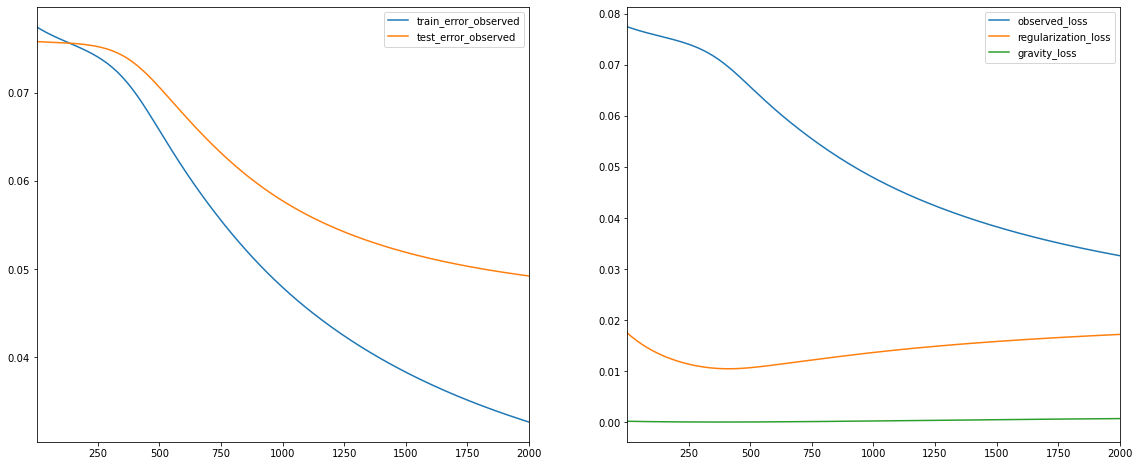

In [124]:
reg_model, u, v  = build_regularized_model(xyz, regularization_coeff=0.1, gravity_coeff=1.0, embedding_dim=35, init_stddev=.05)
reg_model.train(num_iterations=2000, learning_rate=20.)

Let's test our model on a group of artists to get a better understanding of it's recommendations.

In [125]:
for art in range(len(artist_grp)):
    artist_neighbors(reg_model, artist_grp[art], DOT)
    artist_neighbors(reg_model, artist_grp[art], COSINE)

Nearest neighbors of : Lady Gaga.
[Found more than one matching artist. Other candidates: Lady Gaga VS Christina Aguilera, BeyoncÃ© e Lady Gaga, Lady Gaga feat BeyoncÃ©]


,dot score,names
83,11.149323,Lady Gaga
283,4.525960,Britney Spears
282,3.016233,Rihanna
673,2.420350,Glee Cast
289,2.284751,BeyoncÃ©
49,2.130238,Kylie Minogue


Nearest neighbors of : Lady Gaga.
[Found more than one matching artist. Other candidates: Lady Gaga VS Christina Aguilera, BeyoncÃ© e Lady Gaga, Lady Gaga feat BeyoncÃ©]


,cosine score,names
83,1.000000,Lady Gaga
638,0.694369,Inna
629,0.667333,Teen Angels
7188,0.653419,Jay Sean
525,0.640803,Taio Cruz
4704,0.619135,Natalia Kills


Nearest neighbors of : The Killers.
[Found more than one matching artist. Other candidates: Arctic Monkeys vs The Killers]


,dot score,names
223,2.163726,The Killers
201,1.694752,Arctic Monkeys
433,1.620671,Los Hermanos
221,1.550426,The Beatles
184,1.523253,Muse
418,1.399548,The Strokes


Nearest neighbors of : The Killers.
[Found more than one matching artist. Other candidates: Arctic Monkeys vs The Killers]


,cosine score,names
223,1.000000,The Killers
3390,0.823263,Goo Goo Dolls
419,0.768164,Yeah Yeah Yeahs
4035,0.751401,The Postal Service
204,0.744716,Bloc Party
433,0.740768,Los Hermanos


Nearest neighbors of : Black Eyed Peas.
[Found more than one matching artist. Other candidates: The Black Eyed Peas, Juanes feat.Black Eyed Peas]


,dot score,names
283,1.513303,Britney Spears
282,1.117025,Rihanna
83,1.020691,Lady Gaga
66,0.988980,Depeche Mode
286,0.855596,Christina Aguilera
338,0.799291,Taylor Swift


Nearest neighbors of : Black Eyed Peas.
[Found more than one matching artist. Other candidates: The Black Eyed Peas, Juanes feat.Black Eyed Peas]


,cosine score,names
300,1.000000,Black Eyed Peas
343,0.868265,The Pussycat Dolls
336,0.847331,Colbie Caillat
287,0.826126,Ashlee Simpson
317,0.810750,The Saturdays
314,0.809650,Fergie


Nearest neighbors of : Rihanna.
[Found more than one matching artist. Other candidates: Rihanna (feat. Drake), Jay-Z, Bono, The Edge & Rihanna, RihannaÌ€, Sean Paul ft. Rihanna, Rihanna-remixado REnan, \Eminem f_ Rihanna]


,dot score,names
282,5.163428,Rihanna
283,3.511128,Britney Spears
66,3.286510,Depeche Mode
83,3.016233,Lady Gaga
338,2.232560,Taylor Swift
673,2.056847,Glee Cast


Nearest neighbors of : Rihanna.
[Found more than one matching artist. Other candidates: Rihanna (feat. Drake), Jay-Z, Bono, The Edge & Rihanna, RihannaÌ€, Sean Paul ft. Rihanna, Rihanna-remixado REnan, \Eminem f_ Rihanna]


,cosine score,names
282,1.000000,Rihanna
346,0.739779,Cheryl Cole
380,0.713973,Cascada
300,0.705280,Black Eyed Peas
458,0.705221,3OH!3
321,0.678683,Chris Brown


Nearest neighbors of : Gwen Stefani.
[Found more than one matching artist. Other candidates: Panic! at the Disco feat. Britney Spears and Gwen Stefani]


,dot score,names
283,1.207806,Britney Spears
61,1.098422,Madonna
83,1.024359,Lady Gaga
286,0.875029,Christina Aguilera
66,0.825051,Depeche Mode
49,0.720191,Kylie Minogue


Nearest neighbors of : Gwen Stefani.
[Found more than one matching artist. Other candidates: Panic! at the Disco feat. Britney Spears and Gwen Stefani]


,cosine score,names
519,1.000000,Gwen Stefani
459,0.863260,Jessica Simpson
321,0.820368,Chris Brown
323,0.801937,Justin Timberlake
517,0.801173,Lindsay Lohan
304,0.796653,Nelly Furtado


Nearest neighbors of : Eva Simons.
[Found more than one matching artist. Other candidates: Afrojack ft. Eva Simons]


,dot score,names
83,0.279938,Lady Gaga
283,0.277323,Britney Spears
289,0.233170,BeyoncÃ©
282,0.176514,Rihanna
251,0.160372,Mariah Carey
286,0.139491,Christina Aguilera


Nearest neighbors of : Eva Simons.
[Found more than one matching artist. Other candidates: Afrojack ft. Eva Simons]


,cosine score,names
1432,1.000000,Eva Simons
6173,0.686086,Matt Costa
289,0.685343,BeyoncÃ©
5694,0.631218,Masacre
1143,0.614630,Fire Bomber
11784,0.595236,Me and My Dick Cast


These are actually very good recommendations produced by our recommender system based off each users unique normalised values based on the highest listened value they obtained. Our reg_model is much superior on initial inspection than our standard model with much better recommendations all around.

In [126]:
import recmetrics

In [127]:
#tt = reg_model.train(num_iterations=2000, learning_rate=20.)
#recmetrics.coverage_plot(model_names='tt', coverage_scores='played')

# Alternate method - Recommender based on Neural Network

Here we will try to implement another type of recommender system and see does it produce equally as good of results. Our alternate model is based off a neural network to make predictions for users based off listening numbers. As per this article on [Investopedia](https://www.investopedia.com/terms/n/neuralnetwork.asp#:~:text=A%20neural%20network%20is%20a,way%20the%20human%20brain%20operates.&text=Neural%20networks%20can%20adapt%20to,to%20redesign%20the%20output%20criteria.) , a neural network is a series of algorithms that endeavors to recognize underlying relationships in a set of data through a process that mimics the way the human brain operates. Neural networks can adapt to changing input; so the network generates the best possible result without needing to redesign the output criteria. This will help us uncover any listening patterns found in our data by users.

In [128]:
sub = played[['userID', 'artID', 'playedUserNorm']]

In [129]:
sub.head()

,userID,artID,playedUserNorm
0,31,0,0.055775
1,256,0,0.065394
2,729,0,0.025149
3,130,1,0.150902
4,240,1,0.154315


In [130]:
train, test = train_test_split(sub, test_size=0.3, train_size=0.7)

In [133]:
n_users = len(sub.userID.unique())
n_users

1892

In [134]:
n_artist = len(sub.artID.unique())
n_artist

17632

In [135]:
# creating artist embedding path
artist_input = Input(shape=[1], name="Artist-Input")
artist_embedding = Embedding(n_artist + 1, 5, name="Artist-Embedding")(artist_input)
artist_vec = Flatten(name="Flatten-Artist")(artist_embedding)

# creating user embedding path
user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(n_users + 1, 5, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)

# performing dot product and creating model
prod = Dot(name="Dot-Product", axes=1)([artist_vec, user_vec])
model = Model([user_input, artist_input], prod)
model.compile('adam', 'mean_squared_error')

In [136]:
from keras.models import load_model

if os.path.exists('regression_model.h5'):
    model = load_model('regression_model.h5')
else:
    history = model.fit([train.userID, train.artID], train.playedUserNorm, epochs=5, verbose=1)
    model.save('regression_model.h5')
    plt.plot(history.history['loss'])
    plt.xlabel("Epochs")
    plt.ylabel("Training Error")

In [137]:
model.evaluate([test.userID, test.artID], test.playedUserNorm)

11.429469593123153

In [138]:
predictions = model.predict([test.userID.head(10), test.artID.head(10)])

[print(predictions[i], test.playedUserNorm.iloc[i]) for i in range(0,10)]

[1.3035811] 0.14639529180971064
[5.722515] 0.0687221396731055
[2.5226977] 0.23204689789936492
[1.1344862] 0.0730816077953715
[-0.06297127] 0.02364066193853428
[7.122921] 0.08571974035891562
[5.270552] 0.06682158778336338
[4.7006917] 0.49617151607963245
[2.358046] 0.4305555555555556
[1.2106142] 0.4888888888888889


[None, None, None, None, None, None, None, None, None, None]

# Neural Network

In [139]:
# creating book embedding path
artist_input = Input(shape=[1], name="Artist-Input")
artist_embedding = Embedding(n_artist + 1, 5, name="Artist-Embedding")(artist_input)
artist_vec = Flatten(name="Flatten-Artists")(artist_embedding)

# creating user embedding path
user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(n_users + 1, 5, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)

# concatenate features
conc = Concatenate()([artist_vec, user_vec])

# add fully-connected-layers
fc1 = Dense(128, activation='relu')(conc)
fc2 = Dense(32, activation='relu')(fc1)
out = Dense(1)(fc2)

# Create model and compile it
model2 = Model([user_input, artist_input], out)
model2.compile('adam', 'mean_squared_error')

In [140]:
from keras.models import load_model

if os.path.exists('regression_model2.h5'):
    model2 = load_model('regression_model2.h5')
else:
    history = model2.fit([train.userID, train.artID], train.playedUserNorm, epochs=5, verbose=1)
    model2.save('regression_model2.h5')
    plt.plot(history.history['loss'])
    plt.xlabel("Epochs")
    plt.ylabel("Training Error")

In [141]:
model2.evaluate([test.userID, test.artID], test.playedUserNorm)

1934263.1482711572

In [142]:
predictions = model2.predict([test.userID.head(10), test.artID.head(10)])

[print(predictions[i], test.playedUserNorm.iloc[i]) for i in range(0,10)]

[2481.7197] 0.14639529180971064
[1026.1852] 0.0687221396731055
[236.44543] 0.23204689789936492
[640.5943] 0.0730816077953715
[264.38745] 0.02364066193853428
[284.46906] 0.08571974035891562
[250.13684] 0.06682158778336338
[1146.5778] 0.49617151607963245
[273.35706] 0.4305555555555556
[265.46265] 0.4888888888888889


[None, None, None, None, None, None, None, None, None, None]

# Visualizing Embeddings

Next, we will visualize our artist embeddings. As per this article [here](https://towardsdatascience.com/recommender-systems-from-learned-embeddings-f1d12288f278), embeddings can be defined as "vector representations of an entity. Each item in the vector represents a feature or a combination of features for that entity".

In [143]:
# Extract embeddings
artist_em = model.get_layer("Artist-Embedding")
artist_em_weights = artist_em.get_weights()[0]

In [144]:
artist_em_weights[:5]

array([[ 0.04103883, -0.2710777 ,  0.28193265,  0.01121594, -0.21962109],
       [ 0.42227656, -0.44878516,  0.46648487, -0.12221594, -0.40105212],
       [-0.18079431, -0.13342255,  0.1553544 , -0.3333101 , -0.00778394],
       [ 0.150518  , -0.19249448,  0.1592992 ,  0.12258738, -0.12723902],
       [ 0.2513393 , -0.21272472,  0.1814355 , -0.22018886, -0.13649407]],
      dtype=float32)

<AxesSubplot:>

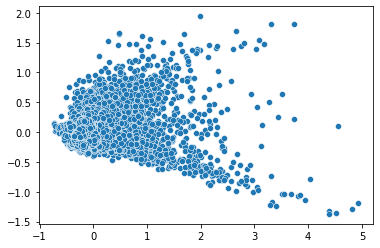

In [145]:
from sklearn.decomposition import PCA
import seaborn as sns

pca = PCA(n_components=2)
pca_result = pca.fit_transform(artist_em_weights)
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1])

In [146]:
artist_em_weights = artist_em_weights / np.linalg.norm(artist_em_weights, axis = 1).reshape((-1, 1))
artist_em_weights[0][:10]
np.sum(np.square(artist_em_weights[0]))

1.0

<AxesSubplot:>

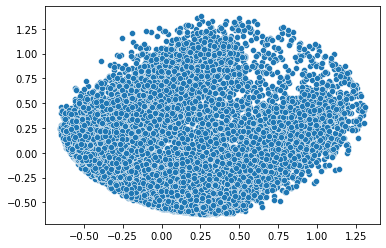

In [147]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(artist_em_weights)
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1])

In [148]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tnse_results = tsne.fit_transform(artist_em_weights)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 17633 samples in 0.046s...
[t-SNE] Computed neighbors for 17633 samples in 1.539s...
[t-SNE] Computed conditional probabilities for sample 1000 / 17633
[t-SNE] Computed conditional probabilities for sample 2000 / 17633
[t-SNE] Computed conditional probabilities for sample 3000 / 17633
[t-SNE] Computed conditional probabilities for sample 4000 / 17633
[t-SNE] Computed conditional probabilities for sample 5000 / 17633
[t-SNE] Computed conditional probabilities for sample 6000 / 17633
[t-SNE] Computed conditional probabilities for sample 7000 / 17633
[t-SNE] Computed conditional probabilities for sample 8000 / 17633
[t-SNE] Computed conditional probabilities for sample 9000 / 17633
[t-SNE] Computed conditional probabilities for sample 10000 / 17633
[t-SNE] Computed conditional probabilities for sample 11000 / 17633
[t-SNE] Computed conditional probabilities for sample 12000 / 17633
[t-SNE] Computed conditional probabilities for sa

<AxesSubplot:>

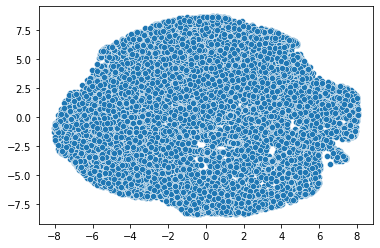

In [149]:
sns.scatterplot(x=tnse_results[:,0], y=tnse_results[:,1])

# Making Recommendations

In [150]:
# Creating dataset for making recommendations for a user
artist_data = np.array(list(set(sub.artID)))
artist_data

array([    0,     1,     2, ..., 17629, 17630, 17631])

Let's pick a random user to generate recommendations for. We will go with the user of ID equalling 83.

In [151]:
user = np.array([83 for i in range(len(artist_data))])
user

array([83, 83, 83, ..., 83, 83, 83])

In [152]:
predictions = model.predict([user, artist_data])

predictions = np.array([a[0] for a in predictions])

recommended_artist_ids = (predictions).argsort()[:10]

recommended_artist_ids

array([8131, 8135, 8324, 2754, 8139, 8317, 8151, 8136, 8315, 2729],
      dtype=int64)

In [153]:
predictions[recommended_artist_ids]

array([-1.1105492 , -1.0870131 , -1.0431927 , -0.9887378 , -0.98679465,
       -0.9674966 , -0.9587735 , -0.9441766 , -0.9026226 , -0.89995944],
      dtype=float32)

In [154]:
df[df['artID'].isin(recommended_artist_ids)]

,name,url,pictureURL,artID
2729,Deathspell Omega,http://www.last.fm/music/Deathspell+Omega,http://userserve-ak.last.fm/serve/252/54245367...,2729
2754,Dark Funeral,http://www.last.fm/music/Dark+Funeral,http://userserve-ak.last.fm/serve/252/13074411...,2754
8131,Nahash,http://www.last.fm/music/Nahash,http://userserve-ak.last.fm/serve/252/93322.jpg,8131
8135,Krabaras,http://www.last.fm/music/Krabaras,http://userserve-ak.last.fm/serve/252/44372179...,8135
8136,DiktatÅ«ra,http://www.last.fm/music/Diktat%C5%ABra,http://userserve-ak.last.fm/serve/252/165489.jpg,8136
8139,Luctus,http://www.last.fm/music/Luctus,http://userserve-ak.last.fm/serve/252/8688989.jpg,8139
8151,Anubi,http://www.last.fm/music/Anubi,http://userserve-ak.last.fm/serve/252/27058983...,8151
8315,Gallhammer,http://www.last.fm/music/Gallhammer,http://userserve-ak.last.fm/serve/252/607745.jpg,8315
8317,Ossastorium,http://www.last.fm/music/Ossastorium,http://userserve-ak.last.fm/serve/252/51798.jpg,8317
8324,Dissimulation,http://www.last.fm/music/Dissimulation,http://userserve-ak.last.fm/serve/252/16340589...,8324


Let's check does our recommender produce novel results. In our recommender system as mentioned earlier it can be hard to gauge good recommenders in a formal manner (not a subjective manner such as a user rating the recommendations) as there is no ratings just listening figures. Users would eventually tire of being suggested the same artists so checking our recommender to see if it produces novel results is a good barometer of it's quality to start.

In [155]:
test = played[played['userID'] == 83]

In [156]:
test[test['artID'].isin(recommended_artist_ids)]

,name,url,artID,userID,artistID,played,playedUserNorm,playCountScaled


Our recommender has produced completely novel results here for the user. This is potentially a good starting point for our recommender. Let's delve further into it's results looking at the recommendations for this particular user.

In [157]:
usert = tags[tags['userID'] == 83]

In [158]:
m = usert['tagValue'].unique()

In [159]:
tagtest =  pd.merge(usert, test, how="inner", left_on=['userID', 'artistID'], right_on=['userID', 'artistID'])

In [160]:
tagtest

,tagID,tagValue,userID,artistID,name,url,artID,played,playedUserNorm,playCountScaled
0,102,hip-hop,83,288,Leona Lewis,http://www.last.fm/music/Leona+Lewis,288,76,0.575758,0.000213
1,103,rap,83,288,Leona Lewis,http://www.last.fm/music/Leona+Lewis,288,76,0.575758,0.000213
2,167,rnb,83,288,Leona Lewis,http://www.last.fm/music/Leona+Lewis,288,76,0.575758,0.000213
3,304,hip hop,83,288,Leona Lewis,http://www.last.fm/music/Leona+Lewis,288,76,0.575758,0.000213


In [161]:
zzzz = df[df['artID'].isin(recommended_artist_ids)]

In [162]:
zzzz1 = pd.merge(zzzz, tags, how="inner", left_on=['artID'], right_on=['artistID'])

In [163]:
zzzz1.head(15)

,name,url,pictureURL,artID,tagID,tagValue,userID,artistID
0,Deathspell Omega,http://www.last.fm/music/Deathspell+Omega,http://userserve-ak.last.fm/serve/252/54245367...,2729,16,new wave,666,2729
1,Deathspell Omega,http://www.last.fm/music/Deathspell+Omega,http://userserve-ak.last.fm/serve/252/54245367...,2729,16,new wave,1525,2729
2,Deathspell Omega,http://www.last.fm/music/Deathspell+Omega,http://userserve-ak.last.fm/serve/252/54245367...,2729,16,new wave,1561,2729
3,Deathspell Omega,http://www.last.fm/music/Deathspell+Omega,http://userserve-ak.last.fm/serve/252/54245367...,2729,18,electronic,264,2729
4,Deathspell Omega,http://www.last.fm/music/Deathspell+Omega,http://userserve-ak.last.fm/serve/252/54245367...,2729,18,electronic,458,2729
5,Deathspell Omega,http://www.last.fm/music/Deathspell+Omega,http://userserve-ak.last.fm/serve/252/54245367...,2729,18,electronic,666,2729
6,Deathspell Omega,http://www.last.fm/music/Deathspell+Omega,http://userserve-ak.last.fm/serve/252/54245367...,2729,18,electronic,1115,2729
7,Deathspell Omega,http://www.last.fm/music/Deathspell+Omega,http://userserve-ak.last.fm/serve/252/54245367...,2729,18,electronic,1525,2729
8,Deathspell Omega,http://www.last.fm/music/Deathspell+Omega,http://userserve-ak.last.fm/serve/252/54245367...,2729,18,electronic,1561,2729
9,Deathspell Omega,http://www.last.fm/music/Deathspell+Omega,http://userserve-ak.last.fm/serve/252/54245367...,2729,39,dance,348,2729


### Let's Evaluate our NN system's recommendations
Let's try calculate precision here for values. We will look to see what tags have been assigned by user 83 that has been assigned to the recommended artists our NN has left them. If at least one tag is found in both the user and the recommended artists tags we assign a score of 1 (relevant) to our user. I will use a method of "precision at K". It is commonly used for evaluating music recommender systems. Out of the first K artists recommended we see how many of these are deemed relevant. As mentioned earlier our relevance can be deemed as an artist who has been given a tag by other users that is also a tag given by the user in question, user 83. I feel this is the most practical method of evaluating this NN system. Anyone with experience of using Spotify or SoundCloud would see that for recommendations you would only look at the first few maybe and lose interest after that. It is also hoped the first few recommendations are of a higher quality and more likely to attract a user's attention.

In [164]:
d = {}
valz = np.array(zzzz1['tagValue'])
vals = np.array(zzzz1['name'])
for i in range(len(valz)):
    if vals[i] not in d:
        d[vals[i]] = ""
    else:
        continue
print(d)

{'Deathspell Omega': '', 'Dark Funeral': '', 'Nahash': '', 'Krabaras': '', 'DiktatÅ«ra': '', 'Luctus': '', 'Anubi': '', 'Gallhammer': '', 'Ossastorium': '', 'Dissimulation': ''}


In [165]:
valz = np.array(zzzz1['tagValue'])
vals = np.array(zzzz1['name'])
for i in range(len(valz)):
    if vals[i] in d and valz[i] in m:
        if valz[i] not in d[vals[i]]:
            d[vals[i]] += valz[i] + ","
    else:
        continue

In [166]:
def strip_dict(d):
    return dict((k.strip(), v.strip()) for k, v in d.items())

In [167]:
strip_dict(d)

{'Deathspell Omega': 'electronic,dance,electropop,',
 'Dark Funeral': 'rock,female vocalists,',
 'Nahash': '',
 'Krabaras': '',
 'DiktatÅ«ra': '',
 'Luctus': '',
 'Anubi': '',
 'Gallhammer': 'rock,',
 'Ossastorium': 'electronic,',
 'Dissimulation': ''}

In [168]:
for key, value in d.items():
    d[key] = value.split(",")

In [169]:
for k, v in d.items():
    v.pop()

In [170]:
d

{'Deathspell Omega': ['electronic', 'dance', 'electropop'],
 'Dark Funeral': ['rock', 'female vocalists'],
 'Nahash': [],
 'Krabaras': [],
 'DiktatÅ«ra': [],
 'Luctus': [],
 'Anubi': [],
 'Gallhammer': ['rock'],
 'Ossastorium': ['electronic'],
 'Dissimulation': []}

In [171]:
l1 = list(d.items())
#print(l1)
count = 0
for i in range(len(l1)):
    if len(l1[i][1]) > 0:
        count += 1
    else:
        continue
print("Precision at k equal 10 for user 83 with tags information is: " + str(count / len(l1)))

Precision at k equal 10 for user 83 with tags information is: 0.4


It is interesting to note that for this user there is a precision score of 0.4. While as discussed below we thought the results were poor there appears to be some sense to our neural network recommender after all.

Looking at these initial results the recommendations didn't seen incredibly accurate for this user. Going by the tags they left they appear to be a keen fan of 'rnb', 'hip-hop' and 'rap'. We also see they like 'pop' and 'soul' music. However, the genres returned here didn't appear to align with this whatsoever. Initially it appeared to have just returned the most popular genres (rock was most popular tag from our earlier analysis) and misses the point. It could definitely be interpreted as good for a user to return completely different types of music opening their eyes to new artists. Admittedly, the user had a high normalised played value of over 50% for this artist (Leona Lewis) they left tags for so obviously it indicates they are a big fan of these genres / artist(s). However, with our precision value here for the top 5 recommended artists we see some sense in the recommendations provided. While they are maybe not massively obvious they do appear to make some type of sense now. The first recommended artist for example 'Dark Funeral' has two tags in common and the fact these tags were given multiple times gives this a more reliable outlook, the same is also true of 'Deathspell Omega' with 3 relevant tags found here.

# Spotify Recommender system

Here I will attempt to test my recommender system on my own personal spotify account to see what recommendations it provides. While it must be noted my music taste is not exactly mainstream for the most part, this should be a good test of the sturdiness of the recommender system. We will be using our first recommender system based on user and artist ID and each users uniquely normalised listening column.

In [172]:
import tekore as tk

In [173]:
# covering these details
client_id = '#'
client_secret = '#'

In [174]:
redirect_url = 'https://example.com/callback'

In [175]:
conf = (client_id, client_secret, redirect_url)
token = tk.prompt_for_user_token(*conf, scope = tk.scope.every)

spotify = tk.Spotify(token)

# paste in link from new webpage opened up by this spotify call above into cell below

Opening browser for Spotify login...
Please paste redirect URL: https://example.com/callback?code=AQAE5ErqRfiwIzsnZ9i02B2Wxg2znJDSEnJ-kVtqd5Yed35zt_G8kBjlte-zkx9WKymWBq2b58GJFHhknVdMHUb9CWxMUpLcabL9KWtV7MU8hMhi4J0yM4D1OoApmyIAX3OgAFrNG0g1pwjTAmOJc8vkbTyrH6YgSYxi5di3zqbYmXYY_n_fF4eVQw20nYx8feqHI9qMJZ52g_n14MYb914t1M2L3hKW06LUaW9qH0EtiKDhPCrGLhoj6BUz3vGz-VrXDCXMaFJNQ5_lCzbArT61VAnqBvk6iZVL8UdgA8coMCzOvZQsbuPojwF629H23Wc4yOQgGnfvmdkd05R8SoGh1e9mvngbqN3M-45DtZeg5s7-x5JWxvf5wcxksuSCRriGWm_h92JZfLs9xjVckdP5dZ1ZNQVkZ8FJe44NTT_v_xl8hsZPnk2XYdewcBAJ-oilkZAm1-CIMW6cZct6ppLL_VHntpL8bJdeAU8QyTM4wH57BromF4vJOO0vOx42XqSqnJAWsYWjYosGcO8PqFwh_qZf3b5TbjMSgpe0zh_bObbo62pFM8cs5rRiEWnoYjqh-2I7g_oaWDx65JVjOzZtvVSmw6CUxn4PrKQjO0i5p8lkicANVuWMXDiu-RLHNox2rvfemGNBiuuqDJyW_yBIQivwxu4Mn12H1wfYYkHS86E&state=AdSDJGOEmp6TaIHE7OhM5h7N139_45TkNGm0QmkbXS4


In [176]:
artists = spotify.current_user_top_artists(limit = 10)
spotify_artists = artists.items

In [177]:
t = np.array(df['name'])
for i in range(len(spotify_artists)):
    if spotify_artists[i].name in t: 
        artist_neighbors(reg_model, spotify_artists[i].name, DOT)
        artist_neighbors(reg_model, spotify_artists[i].name, COSINE)
    else:
        print(str(spotify_artists[i].name) + " is not in the LastFM data.")

Nearest neighbors of : Calvin Harris.


,dot score,names
83,0.850127,Lady Gaga
673,0.603270,Glee Cast
201,0.602046,Arctic Monkeys
283,0.591399,Britney Spears
492,0.584087,Paramore
49,0.558559,Kylie Minogue


Nearest neighbors of : Calvin Harris.


,cosine score,names
1400,1.000000,Calvin Harris
292,0.865796,Lily Allen
424,0.854708,Kate Nash
3180,0.849887,Cansei de Ser Sexy
2068,0.837903,M.I.A.
3090,0.833644,Fiona Apple


Mark Blair is not in the LastFM data.
Bissett is not in the LastFM data.
Tobu is not in the LastFM data.
Nearest neighbors of : David Guetta.
[Found more than one matching artist. Other candidates: Chris Willis; David Guetta; Fergie; LMFAO]


,dot score,names
283,1.685521,Britney Spears
282,1.078436,Rihanna
83,1.057136,Lady Gaga
286,0.957173,Christina Aguilera
61,0.932119,Madonna
492,0.924621,Paramore


Nearest neighbors of : David Guetta.
[Found more than one matching artist. Other candidates: Chris Willis; David Guetta; Fergie; LMFAO]


,cosine score,names
322,1.000000,David Guetta
312,0.860556,Hilary Duff
399,0.853456,The Rasmus
517,0.825308,Lindsay Lohan
536,0.824755,Pitty
336,0.798463,Colbie Caillat


Low Steppa is not in the LastFM data.
Uniting Nations is not in the LastFM data.
Sonny Fodera is not in the LastFM data.
Nearest neighbors of : Eric Prydz.


,dot score,names
221,0.090090,The Beatles
1663,0.086734,Avenged Sevenfold
492,0.074269,Paramore
61,0.064041,Madonna
1240,0.059517,Guns N' Roses
469,0.058974,Eminem


Nearest neighbors of : Eric Prydz.


,cosine score,names
2494,1.000000,Eric Prydz
5129,0.614213,Juango DÃ¡valos
17481,0.573825,Anna Tatangelo
1339,0.543666,Alestorm
910,0.541264,Savatage
6648,0.539831,Under Line


Pete Heller's Big Love is not in the LastFM data.


#### Personal Opinions on these recommendations
As referenced earlier some of these artists aren't exactly mainstream, massively popular artists to a wider audience, hence the limited number of found artists. Calvin Harris and David Guetta are popular artists and the recommendations made by our recommender are actually good between dot score and cosine scores. The recommendations for Eric Prydz are not quite as good it has to be said especially for cosine scores. This may be due to lack of appropriate artists similar to Eric Prydz in the LastFM data as it would be a more obscure artist. The cosine and dot scores provided for this artists would appear to suggest this as they are noticeably lower than previous scores. However, on the whole I definitely find these recommendations quite good. These artists recommended are definitely not in my more popular artists and it is a good sign of the recommender system it is showing new artists. The recommendations for David Guetta and Calvin Harris are in my opinion very logical. There is artists that have collaborated with the pair in both sets of recommendations and other artists of a similar ilk who are not in my top artists. The Eric Prydz results do highlight some of the limitations of our approach. With the values scaled from just 0 to 1 scores with similar listening values will be aligned regardless of genre of user's preferences. It must also be noted this dataset is from 2011 so the recommendations are based off a slightly more limited market of artists too which is why some of these artists could not be found and why some recommendations may be slightly more predictable.

# Evaluation

We will now try to evaluate our results and methods attempted so far. I will look at using methods such as Recall, Precision, Coverage and F1 to validate our methods. I feel methods such as mean absolute error (MAE) and root mean square error (RMSE) are not suitable to our data provided. These look at the difference between the actual and predicted values, which are not really applicable to the data here. The predicted artist could be number 1 and the actual artist could be 2 and this would appear as a very good result using this method. However, the difference in genres and similarity of artist could be completely different and hence the result is misleading. We will look to implement evaluation using the "LightFM" python library.

In [178]:
import implicit
from tqdm import tqdm_notebook as tqdm
import matplotlib.ticker as ticker
from matplotlib import rc
from pandas.api.types import CategoricalDtype
import string
import re
import random
import math
from math import sqrt
from math import log
from collections import Counter, defaultdict
from operator import itemgetter
from pylab import rcParams
from pylab import savefig

In [184]:
# Create sparse matrix from dataframe object
def create_sparse_matrix(data):
  #get unique user ids and unique artist ids
  users = list(np.sort(data.userID.unique()))
  artists = list(data.artistID.unique())
  plays = list(data.playedUserNorm)

  cat_type = CategoricalDtype(categories=users, ordered=True)
  rows = data.userID.astype(cat_type).cat.codes

  cat_type = CategoricalDtype(categories=artists, ordered=True)
  cols = data.artistID.astype(cat_type).cat.codes
  # we get the rows (user ids) and columns (artist ids) and populate them using plays
  plays_sparse = scipy.sparse.csr_matrix((plays, (rows, cols)), shape=(len(users),len(artists)))
  return plays_sparse

In [180]:
# Calculate sparsity of matrix
def calculate_sparsity(M):
  matrix_size = float(M.shape[0] * M.shape[1]) # Number of total possible interactions between artist and user in the matrix
  num_plays = len(M.nonzero()[0]) # Number of times any artist has been interacted with
  sparsity = 100 * (1 - float(num_plays / matrix_size))
  return sparsity

In [181]:
def evaluate_lightfm(model, original, train, test, user_features=None, item_features=None, n_rec = 20):
    print("Evaluating LightFM...")
    print("Calculating Coverage...")
    catalog = []
    for user in tqdm(range(0, original.shape[0])):
      #get scores for this particular user for all artists
      rec_scores = model.predict(user,np.arange(original.shape[1]),user_features=user_features, item_features=item_features)
      #get top k items to recommend
      rec_items = (-rec_scores).argsort()[:20]
      #calculate coverage
      #coverage calculation
      for recs in rec_items:
        if recs not in catalog:
          catalog.append(recs)
            
    coverage = len(catalog)/float(original.shape[1])
    print("Calculating Recall at k...")
    recall = recall_at_k(model, test, user_features = user_features, item_features = item_features, k = n_rec).mean()
    print("Calculating Precision at k...")
    precision = precision_at_k(model, test, user_features = user_features, item_features = item_features, k = n_rec).mean()
    f1 = (2 * precision * recall) / (precision + recall)
    return coverage, precision, recall, f1

In [186]:
playedx = played[['userID','artistID', 'playedUserNorm']]
playedx.columns = ['userID','artistID', 'playedUserNorm']

#create sparse matrix like earlier
plays_sparse_light = create_sparse_matrix(playedx).astype('float')
print('Matrix Sparsity:', calculate_sparsity(plays_sparse_light))

train_ratings, test_ratings = split_dataframe(xyz)
# SparseTensor representation of the train and test datasets.
A_train = build_rating_sparse_tensor(train_ratings)
A_test = build_rating_sparse_tensor(test_ratings)

train_light, test_light = lightfm.cross_validation.random_train_test_split(plays_sparse_light, test_percentage = 0.7)
model_fm_vanilla = LightFM(learning_rate=0.05, loss='bpr')

#train model
print("Fitting model...")
model_fm_vanilla.fit(train_light, epochs=10)

#evaluate model
coverage, precision, recall, f1 = evaluate_lightfm(model_fm_vanilla, plays_sparse_light, train_light, test_light)
print("Precision:", precision * 100, '%')
print("Recall:", recall * 100, '%')
print("Coverage:", coverage * 100, '%')
print("F1:", f1 * 100, '%')

Matrix Sparsity: 99.72171848800758
Fitting model...
Evaluating LightFM...
Calculating Coverage...


C:\Users\user\AppData\Local\Temp/ipykernel_27996/314659252.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for user in tqdm(range(0, original.shape[0])):


  0%|          | 0/1892 [00:00<?, ?it/s]

Calculating Recall at k...
Calculating Precision at k...
Precision: 12.879109382629395 %
Recall: 7.531221890453887 %
Coverage: 0.8337114337568058 %
F1: 9.504542499995978 %


In [183]:
playedx = played[['userID','artistID', 'playCountScaled']]
playedx.columns = ['userID','artistID', 'playCountScaled']

#create sparse matrix like earlier just compatible with lightFM
plays_sparse_light = create_sparse_matrix(playedx).astype('float')
print('Matrix Sparsity:', calculate_sparsity(plays_sparse_light))

# split up data like we did earlier with our split_dataframe function
train_light, test_light = lightfm.cross_validation.random_train_test_split(plays_sparse_light, test_percentage = 0.7)
model_fm_vanilla = LightFM(learning_rate=0.05, loss='bpr')

#train model
print("Fitting model...")
model_fm_vanilla.fit(train_light, epochs=10)

#evaluate model
coverage, precision, recall, f1 = evaluate_lightfm(model_fm_vanilla, plays_sparse_light, train_light, test_light)
print("Precision:", precision * 100, '%')
print("Recall:", recall * 100, '%')
print("Coverage:", coverage * 100, '%')
print("F1:", f1 * 100, '%')

Matrix Sparsity: 99.72362497745786
Fitting model...
Evaluating LightFM...
Calculating Coverage...


C:\Users\user\AppData\Local\Temp/ipykernel_27996/314659252.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for user in tqdm(range(0, original.shape[0])):


  0%|          | 0/1892 [00:00<?, ?it/s]

Calculating Recall at k...
Calculating Precision at k...
Precision: 11.130227893590927 %
Recall: 6.547820483133281 %
Coverage: 0.7372958257713249 %
F1: 8.24511084374583 %


Our chosen accuracy when normalising with each user's max score is actually worse than our play count scaled metric. However, when I ran this with playCountScaled used for our recommender the recommendations were dreadful with very low dot and cosine scores. Of the sample of artists and my spotify recommendations the recommendations using the playedUserNorm column seemed far more accurate. This is probably because the scores are better scaled between 0 and 1, identifying popular artists more easily with values closer to 1 and also less known artists would have a better chance of being noticed if a handful of users listened to them a lot.

# Clustering